In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/teichmann/rl20/TCL/object/TCL_final_raw_soupX_rmdou.h5ad'
adata = sc.read_h5ad(input_file)

In [3]:
adata

AnnData object with n_obs × n_vars = 180332 × 36601
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'broad_cell_type'
    var: 'gene_ids'

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
ribo_genes = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 6302 genes that are detected in less than 3 cells


In [5]:
#sc.settings.set_figure_params(dpi=60, facecolor='white')
#sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
 #            jitter=0.4, multi_panel=True)

In [6]:
adata_backup_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


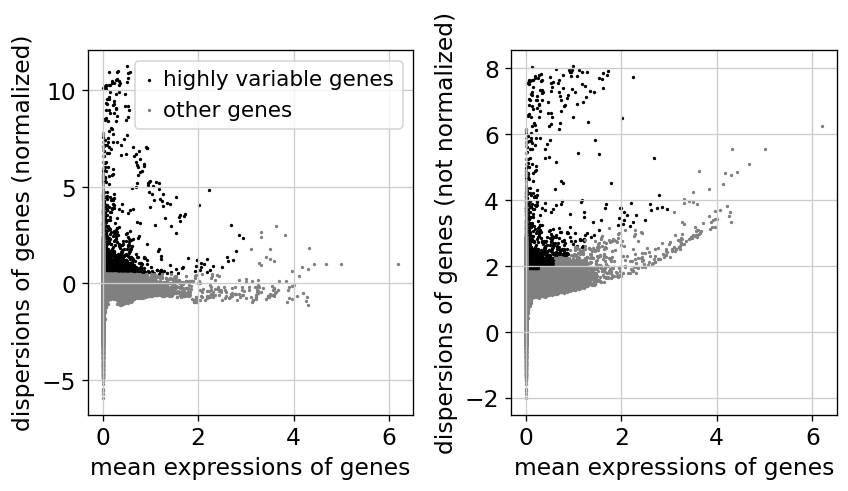

In [7]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [8]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [9]:
sc.pp.scale(adata_filtered, max_value=10)

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:47)


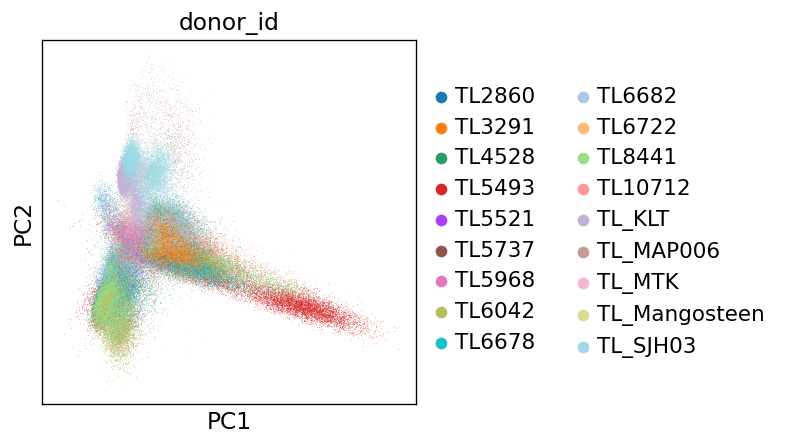

In [10]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor_id'])

In [11]:
#Set harmony variables
pca = np.array(adata_filtered.obsm["X_pca"])
batch = adata_filtered.obs['donor_id']
meta_data = adata_filtered.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered.obsm["X_pca_back"]= adata_filtered.obsm["X_pca"][:]
adata_filtered.obsm["X_pca"] = np.array(res)

2025-08-25 18:29:57,198 - harmonypy - INFO - Iteration 1 of 10
2025-08-25 18:32:54,468 - harmonypy - INFO - Iteration 2 of 10
2025-08-25 18:35:51,141 - harmonypy - INFO - Converged after 2 iterations


In [12]:
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:18)


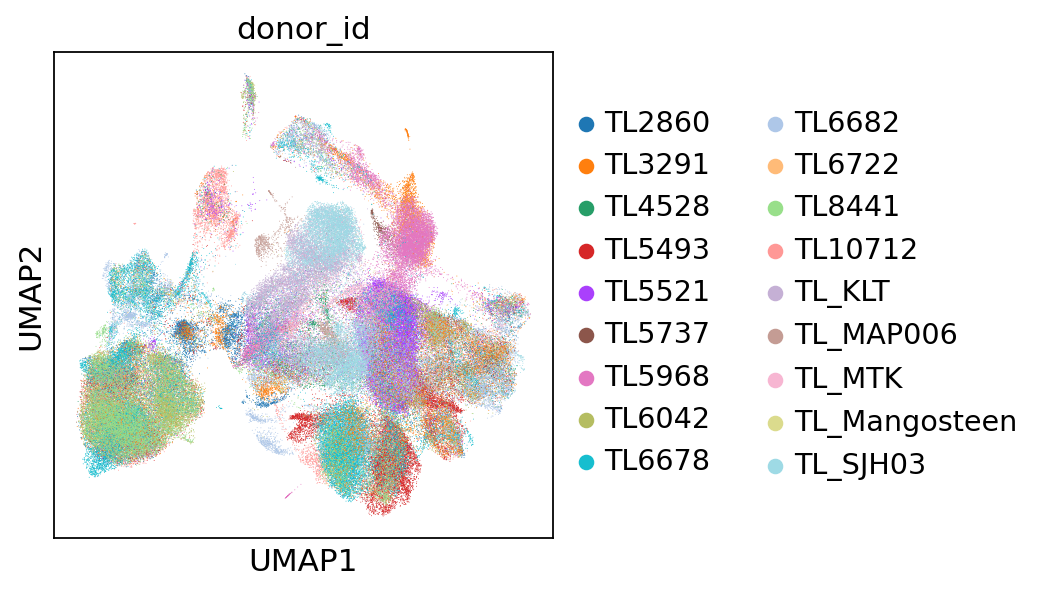

In [13]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.umap(adata_filtered, color=['donor_id'])

In [14]:
col = ['#F35B92','#3E8D0E','#BAB1A7','#60528F',
 '#BFA829','#794FE0','#7982E3','#75CFC1','#EC6CDD',
 '#C2501E','#794FE0','#A1208F']

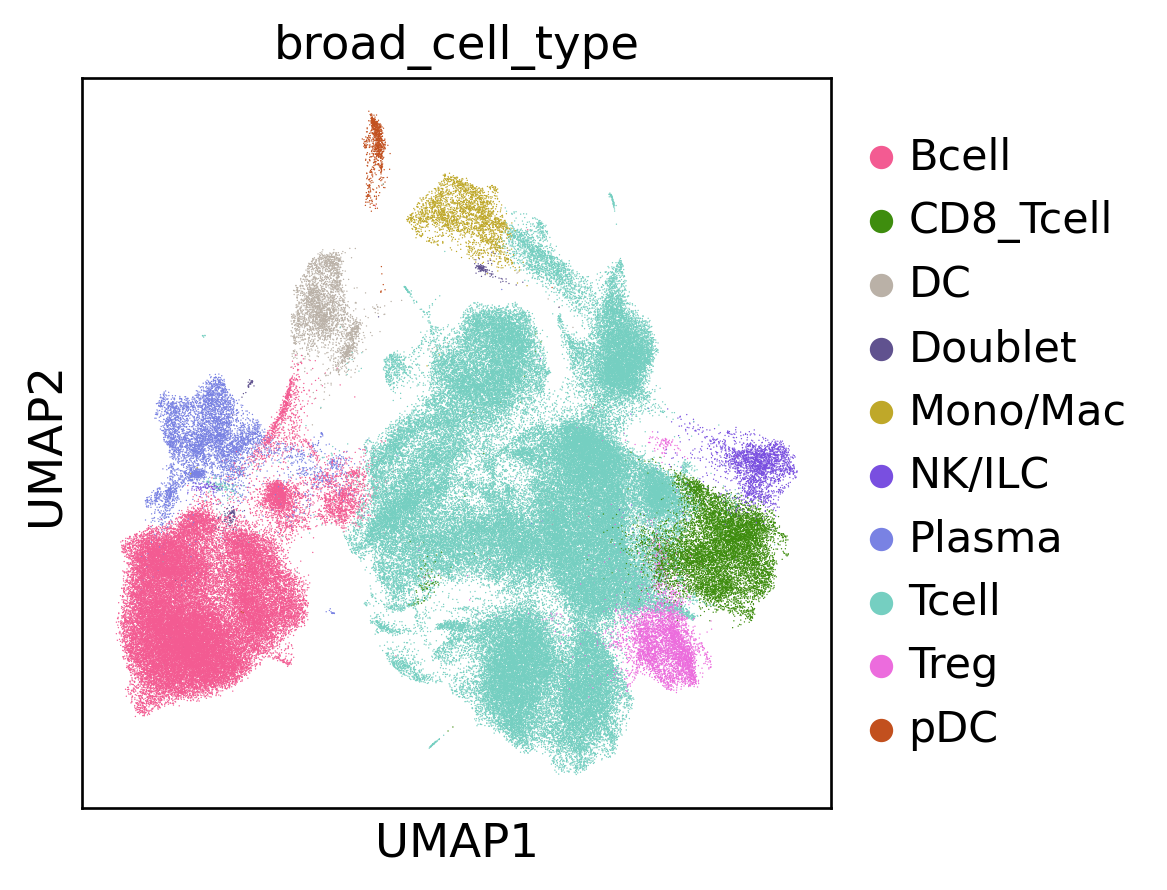

In [17]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered, color=['broad_cell_type'], palette = col)

In [16]:
adata_filtered

AnnData object with n_obs × n_vars = 180332 × 2266
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'broad_cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'donor_id_colors', 'neighbors', 'umap', 'broad_cell_type_colors'
    obsm: 'X_pca', 'X_pca_back', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
save_file = '/lustre/scratch126/cellgen/teichmann/rl20/TCL/object/TCL_final_soupX_harmony_20250825.h5ad'
adata_filtered.write(save_file)

In [18]:
adata_filtered.obs['donor_id_new'] = ''
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL_MTK', 'donor_id_new'] = 'MTx'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL_Mangosteen', 'donor_id_new'] = 'MGx'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL5521', 'donor_id_new'] = 'TLBL2'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL6678', 'donor_id_new'] = 'PTCL1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL5968', 'donor_id_new'] = 'TLBL4'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL5493', 'donor_id_new'] = 'nTFHL-NOS1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL_SJH03', 'donor_id_new'] = 'BIA-ALCL2'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL_KLT', 'donor_id_new'] = 'BIA-ALCL1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL6682', 'donor_id_new'] = 'PTCL4'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL3291', 'donor_id_new'] = 'TLBL1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL6042', 'donor_id_new'] = 'PTCL5'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL10712', 'donor_id_new'] = 'SS1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL2860', 'donor_id_new'] = 'TLBL5'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL4528', 'donor_id_new'] = 'PTCL3'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL8441', 'donor_id_new'] = 'nTFHL-AI1'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL5737', 'donor_id_new'] = 'TLBL3'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL6722', 'donor_id_new'] = 'PTCL2'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL_MAP006', 'donor_id_new'] = 'GR-ALCL-1'

In [22]:
adata_filtered.obs['tumour_type'] = adata_filtered.obs['tumour_type'].replace('PTCL', 'PTCL-NOS')
adata_filtered.obs['tumour_type'] = adata_filtered.obs['tumour_type'].replace('TCL', 'PTCL-NOS')
adata_filtered.obs['tumour_type'] = adata_filtered.obs['tumour_type'].replace('AITL', 'SS')

In [23]:
adata_filtered.obs['tumour_type_new'] = adata_filtered.obs['tumour_type'].copy()
adata_filtered.obs['tumour_type_new'] = adata_filtered.obs['tumour_type_new'].astype('str')
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL5493', 'tumour_type_new'] = 'nTFHL'
adata_filtered.obs.loc[adata_filtered.obs['donor_id']=='TL8441', 'tumour_type_new'] = 'nTFHL'

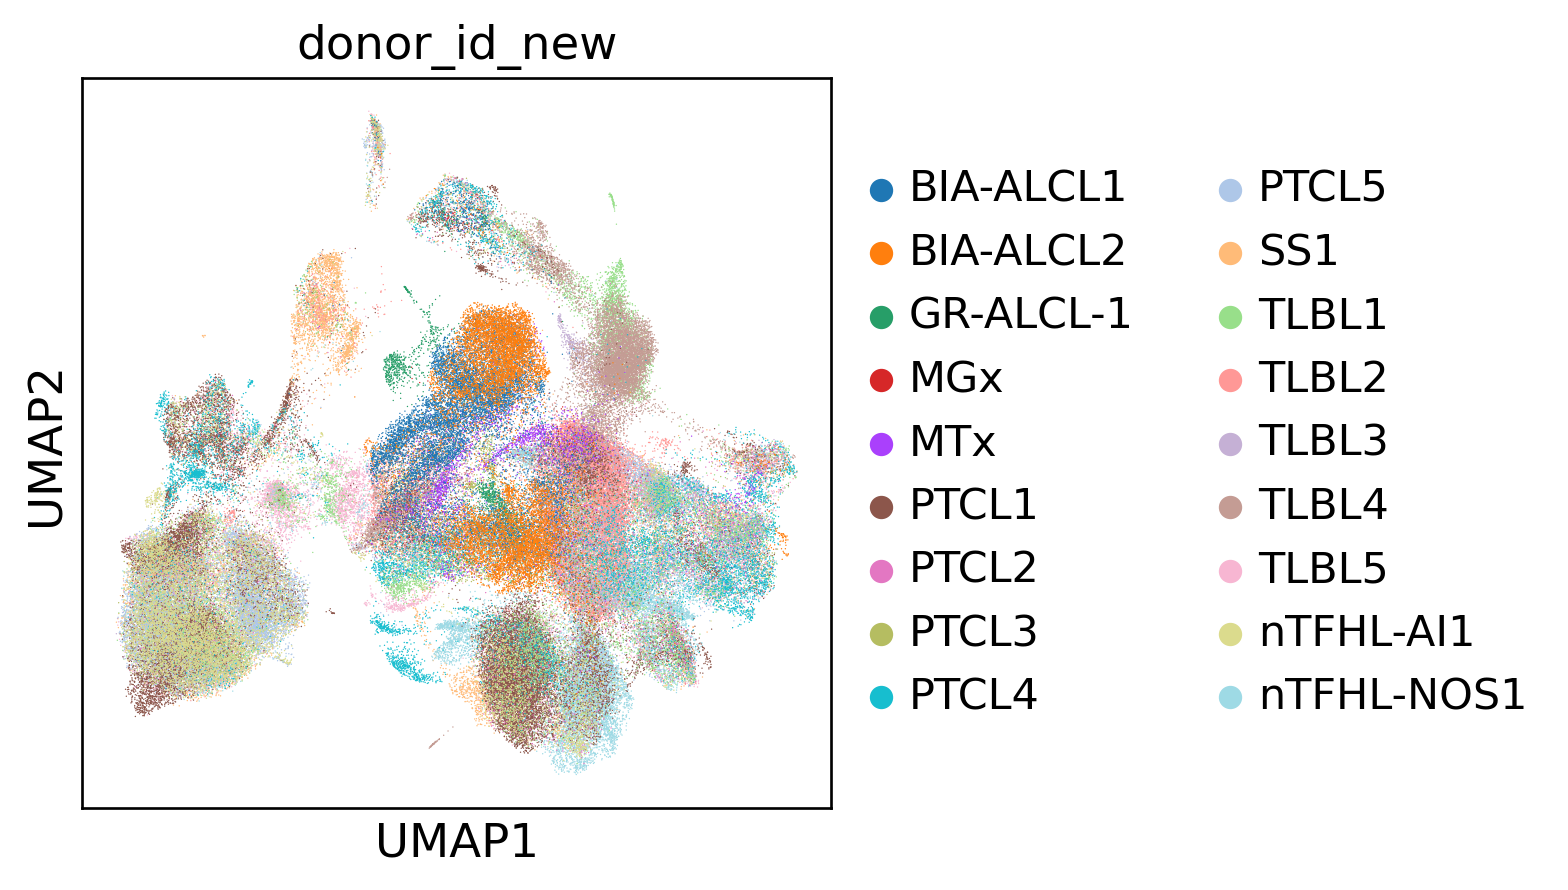

In [20]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered, color=['donor_id_new'])

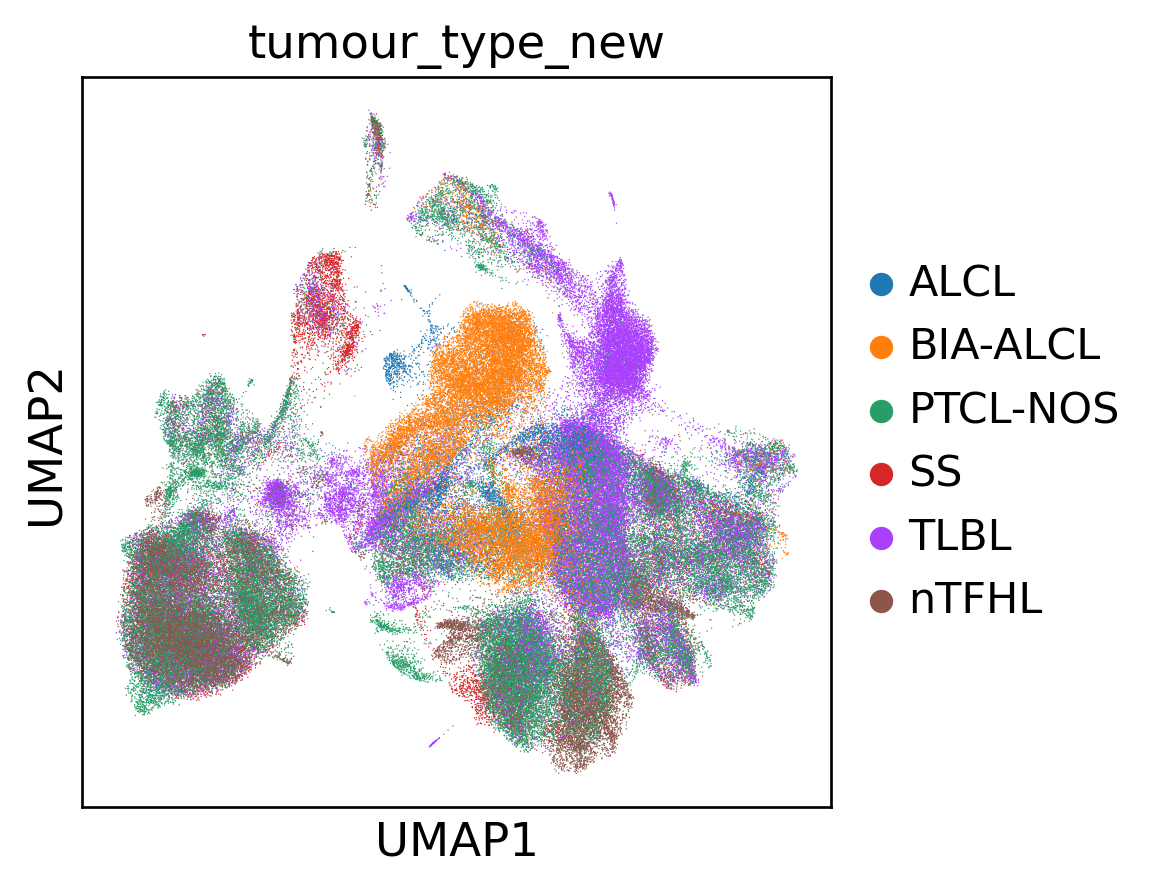

In [24]:
sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered, color=['tumour_type_new'])